In [1]:
import keras
from keras.preprocessing.image import load_img, img_to_array, array_to_img, ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint
from keras.applications import ResNet50

import matplotlib.pyplot as plt
import numpy as np

from cyclical_lr import CyclicLR

Using TensorFlow backend.


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

### Load data

In [5]:
img = load_img('data/lato/img-lato-2018-08-02 14:20:21.119642.jpg')
x = img_to_array(img)

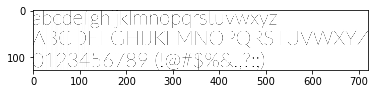

In [6]:
plt.imshow(x/255.)

In [7]:
img_generator = ImageDataGenerator(rotation_range=90.,
                                   featurewise_center=True, 
                                   horizontal_flip=True,
                                   fill_mode='reflect',
                                   vertical_flip=True,
                                   zoom_range=0.4,
                                   featurewise_std_normalization=True,
                                   zca_whitening=False,
                                   width_shift_range=20,
                                   height_shift_range=20,
                                   validation_split=0.2, rescale=1./255)

def get_batches(path, subset, gen=img_generator, 
                shuffle=True, batch_size=8, class_mode='categorical'): 
    return gen.flow_from_directory(path, target_size=(228,228), 
                                   class_mode=class_mode, shuffle=shuffle, batch_size=batch_size, subset=subset)

### Data Augmentation

In [9]:
# img = load_img('data/roboto/img-roboto-2018-08-02 14:15:46.484655.png')  
x = img_to_array(img)  
x = x.reshape((1,) + x.shape)  

In [10]:
!pwd

/Users/raghotham/code/fontastic


In [11]:
# create preview folder

### Transfer Learning with Image Augmentation

In [12]:
from keras.applications import ResNet50

In [13]:
train_generator = get_batches('data/', 'training')
val_generator = get_batches('data/', 'validation')

Found 12508 images belonging to 10 classes.
Found 3122 images belonging to 10 classes.


In [14]:
base_model = ResNet50(include_top=False, input_shape=(228,228,3))

/Users/raghotham/anaconda3/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [15]:
batch_size=16

In [25]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.4)(x)

x = Dense(32, activation='relu')(x)
x = Dropout(0.2)(x)

predictions = Dense(10, activation='softmax')(x)
m = Model(inputs=base_model.input, outputs=predictions)

In [28]:
clr_triangular = CyclicLR(base_lr=0.001, max_lr=0.1, mode='triangular', step_size=2*600//batch_size)

m.compile(optimizer='adam' , loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
m.fit_generator(
        train_generator,
        steps_per_epoch=600 // batch_size,
        epochs=10,
        callbacks=[clr_triangular],
        validation_data=val_generator,
        validation_steps=140 // batch_size)


Epoch 1/10


/Users/raghotham/anaconda3/lib/python3.6/site-packages/keras_preprocessing/image.py:1131: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/Users/raghotham/anaconda3/lib/python3.6/site-packages/keras_preprocessing/image.py:1139: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


In [ ]:

plt.xlabel('Training Iterations' )
plt.ylabel('Learning Rate')
plt.title("CLR - 'triangular' Policy")
plt.plot(clr_triangular.history['iterations'], clr_triangular.history['lr'])